# HLS composite metadata comparison

In [1]:
!pip install plotnine

In [2]:
import sys
import os

import geopandas as gpd
import pandas as pd

#sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils

import datetime


import json
import glob

import s3fs

s3 = s3fs.S3FileSystem(anon=False)

/tmp/ipykernel_4460/1031497145.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### Build a df of the HLS metadata

In [3]:
metadata_json_list = ['s3://'+f for f in s3.glob('s3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/mc*/**/master_*HLS.json')]
metadata_json_list = ['s3://'+f for f in s3.glob('s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2023_v1/HLS_H30*/**/master_*HLS.json')]
metadata_json_list[0]

's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2023_v1/HLS_H30_2020/2023/04/10/18/37/24/844638/master_207_2020-07-01_2020-08-31_HLS.json'

In [ ]:
from multiprocessing import Pool
from functools import partial

with Pool(processes=1) as pool:
    df_list = pool.map(open_s3_json, metadata_json_list)

In [44]:
def open_s3_json(fn):
    with s3.open(fn) as f:
        #data = pd.read_json(f)
        df = pd.json_normalize(json.load(f), record_path=['features'])
        df['filename'] = os.path.basename(fn)
        df['tile_num'] = os.path.basename(fn).split('_')[1]
        df['start'] = os.path.basename(fn).split('_')[2]
        df['start_month'] = os.path.basename(fn).split('_')[2].split('-')[1]
        df['start_year'] = os.path.basename(fn).split('_')[2].split('-')[0]
        df['end_year'] = os.path.basename(fn).split('_')[3].split('-')[0]

        df['end'] = os.path.basename(fn).split('_')[3]
        
        return df

In [4]:
%%time
df_list = []
df_smry_list = []

for fn in metadata_json_list[0:50]:

    with s3.open(fn) as f:
        #data = pd.read_json(f)
        df = pd.json_normalize(json.load(f), record_path=['features'])
        df['filename'] = os.path.basename(fn)
        df['tile_num'] = os.path.basename(fn).split('_')[1]
        df['start'] = os.path.basename(fn).split('_')[2]
        df['start_month'] = os.path.basename(fn).split('_')[2].split('-')[1]
        df['start_year'] = os.path.basename(fn).split('_')[2].split('-')[0]
        df['end_year'] = os.path.basename(fn).split('_')[3].split('-')[0]
        df['doy'] = df['id'].str.split('.', expand=True)[3].str[4:7]

        df_smry = df.groupby(['tile_num','start_year','end_year','collection']).size().reset_index(name='counts')
        df_list.append(df)
        df_smry_list.append(df_smry)

df = pd.concat(df_list)

df_smry = pd.concat(df_smry_list)
df_smry.head()

CPU times: user 1.71 s, sys: 43 ms, total: 1.75 s
Wall time: 6.11 s


,tile_num,start_year,end_year,collection,counts
0,207,2020,2020,HLSL30.v2.0,1
1,207,2020,2020,HLSS30.v2.0,12
0,3160,2020,2020,HLSL30.v2.0,7
1,3160,2020,2020,HLSS30.v2.0,16
0,4122,2020,2020,HLSL30.v2.0,5


AttributeError: 'Figure' object has no attribute 'set_layout_engine'

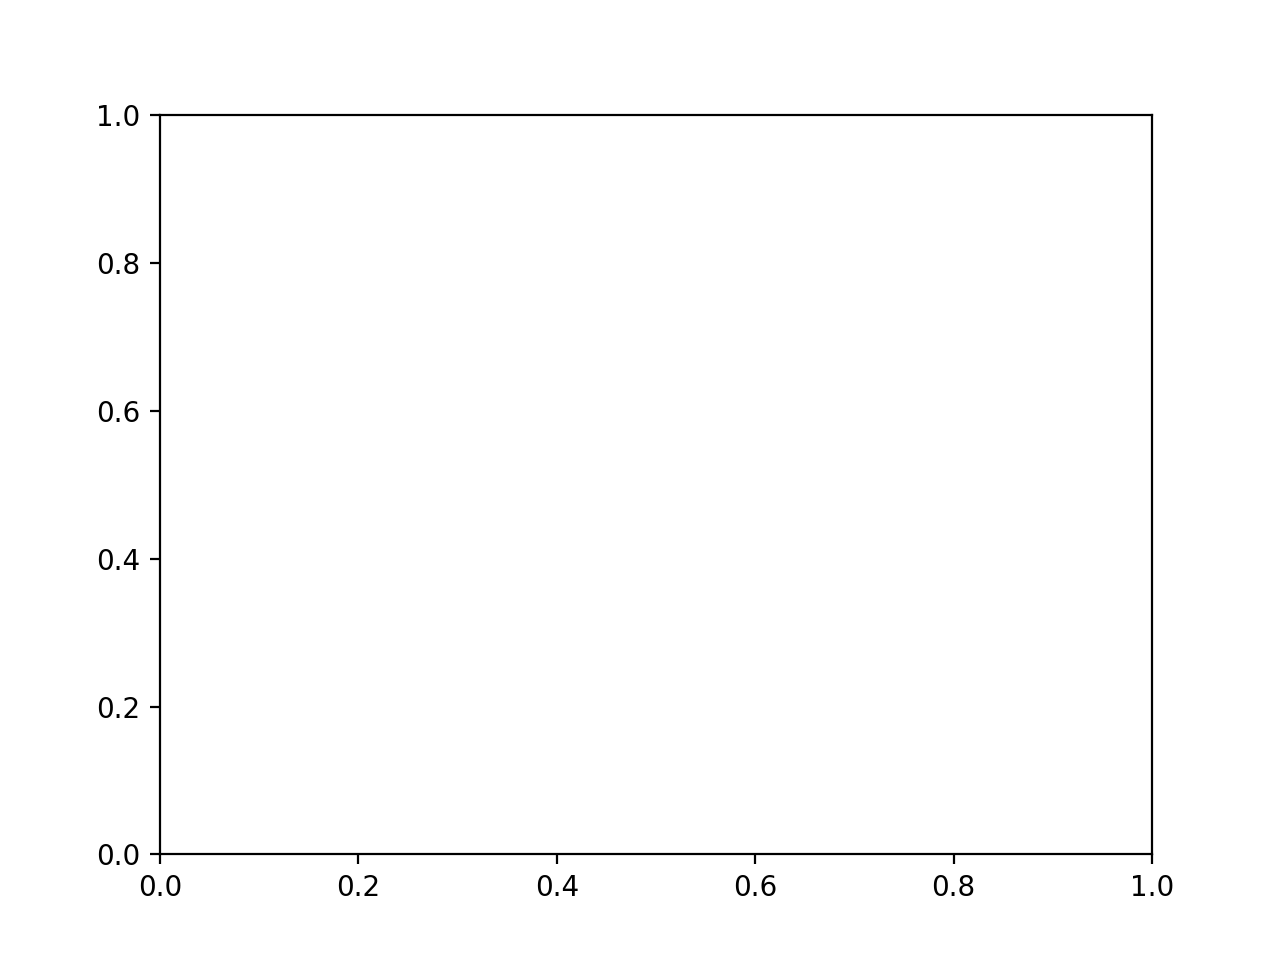

In [16]:
import matplotlib.pyplot as plt
ax = plt.subplot()
var = 'properties.eo:cloud_cover'
p = (ggplot(data = df)
    #+ geom_point(aes(x='start', y=var))
    + geom_bar(aes(x='doy', fill='collection'))
    #+ facet_grid('~end')
    + theme_bw()
    + theme(figure_size=(8, 4)) 
    )
p

In [6]:
import plotnine
from plotnine import *

In [68]:
var = 'properties.eo:cloud_cover'
print(
    ggplot(data = df)
    #+ geom_point(aes(x='start', y=var))
    + geom_boxplot(aes(x='doy', y=var, fill='collection'))
    #+ facet_grid('~end')
    + theme_bw()
    + theme(figure_size=(8, 4)) 
)

AttributeError: 'Figure' object has no attribute 'set_layout_engine'